# Breakdown DEM
This notebook uses the clipped DEM to derive topographical statistics per plot.

In [1]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats
import geopandas as gpd
import os
import matplotlib.pyplot as plt

We want to open the DEM file in meters of elevation, so we can calculate statistics.

In [2]:

dem_path = 'data/DEM/RegressionRidge_DEM.tif'
dem_utm_path = 'data/DEM/RegressionRidge_DEM_utm.tif'  

# Reproject DEM to UTM (meters)
with rasterio.open(dem_path) as src:
    if src.crs.to_epsg() != 32610:  #
        dst_crs = 'EPSG:32610'
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        
        # save a copy of projection for later loading
        with rasterio.open(dem_utm_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.bilinear
                )
        dem_file = dem_utm_path
    else:
        dem_file = dem_path

In [3]:
# Load DEM
with rasterio.open(dem_file) as src:
    dem = src.read(1)   
    transform = src.transform
    nodata = src.nodata
    xres = transform.a
    yres = transform.e

In [4]:
# mask nodata
dem = np.where(dem == nodata, np.nan, dem)

In [5]:
# compute slope and aspect
dy, dx = np.gradient(dem, abs(yres), abs(xres))

# slope in degrees
slope_deg = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))

# aspect in degrees, 0 = north
aspect_rad = np.arctan2(-dx, dy)
aspect_deg = (np.degrees(aspect_rad) + 360) % 360

# elevation deviation
elev_dev = dem - np.nanmean(dem)

/home/simonhans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in remainder
  if __name__ == '__main__':


Now that we have these statistics calculated for our dem, we can apply our polygons and get plot-wide statistics.

First load polygons. Then use rasterstats zonal stats applied to different vineyard-wide computed topographies.

In [6]:
vineyard_path = 'data/polygons/RegressionRidge.geojson'
plots_path = 'data/polygons/RegressionRidge_smol.geojson'

# Load vineyard polygons
vineyard = gpd.read_file(vineyard_path)
vineyard = vineyard.to_crs(crs=rasterio.open(dem_file).crs)
# vineyard.plot()

# Load plot polygons
plots = gpd.read_file(plots_path)
plots = plots.to_crs(crs=rasterio.open(dem_file).crs)
# plots.plot()

In [7]:
def calculate_elevation_statistics(gdf):
    # Compute zonal stats
    slope_stats = zonal_stats(gdf, slope_deg, affine=transform, nodata=np.nan,
                              stats=['mean', 'min', 'max'])
    aspect_stats = zonal_stats(gdf, aspect_deg, affine=transform, nodata=np.nan,
                               stats=['mean', 'min', 'max'])
    
    elev_stats = zonal_stats(gdf, dem, affine=transform, nodata=np.nan,
                             stats=['mean', 'min', 'max'])
    
    elev_dev_stats = zonal_stats(gdf, elev_dev, affine=transform, nodata=np.nan,
                             stats=['mean', 'min', 'max'])

    # Combine into dataframe
    df_features = pd.DataFrame({
        'plot_id': gdf.index,
        'slope_mean': [s['mean'] for s in slope_stats],
        'slope_min': [s['min'] for s in slope_stats],
        'slope_max': [s['max'] for s in slope_stats],
        'aspect_mean': [s['mean'] for s in aspect_stats],
        'aspect_min': [s['min'] for s in aspect_stats],
        'aspect_max': [s['max'] for s in aspect_stats],
        'elev_min': [s['min'] for s in elev_stats],
        'elev_max': [s['max'] for s in elev_stats],
        'elev_mean': [s['mean'] for s in elev_stats],
        'elev_dev_min': [s['min'] for s in elev_dev_stats],
        'elev_dev_max': [s['max'] for s in elev_dev_stats],
        'elev_dev_mean': [s['mean'] for s in elev_dev_stats]
    })

    df_features = df_features.merge(gdf, on = gdf.index)
    df_features['total_relief'] = df_features['elev_max'] - df_features['elev_min']

    gdf_features = gpd.GeoDataFrame(df_features, geometry=gdf.geometry, crs=gdf.crs)
    return gdf_features

# calculate vineyard-wide statistics
vineyard_features = calculate_elevation_statistics(vineyard)

# calculate plot-level statistics
plot_features = calculate_elevation_statistics(plots)

# set vineyard plot id to append to full df
vineyard_features.loc[0, 'plot_id'] = 'full'

df_features = pd.concat([plot_features, vineyard_features])
gdf_features = gpd.GeoDataFrame(
    df_features,
    geometry=df_features['geometry'], 
    crs=rasterio.open(dem_file).crs
)


In [8]:
# compute area in square meters
gdf_features['area_m2'] = gdf_features.geometry.area

# convert to hectares -- commonly used in agg
gdf_features['area_ha'] = gdf_features['area_m2'] / 10000

In [9]:
# select pot features. index 65 is teh full vineyard
plot_features = gdf_features.reset_index().loc[0:64]

Now to visualize our work!

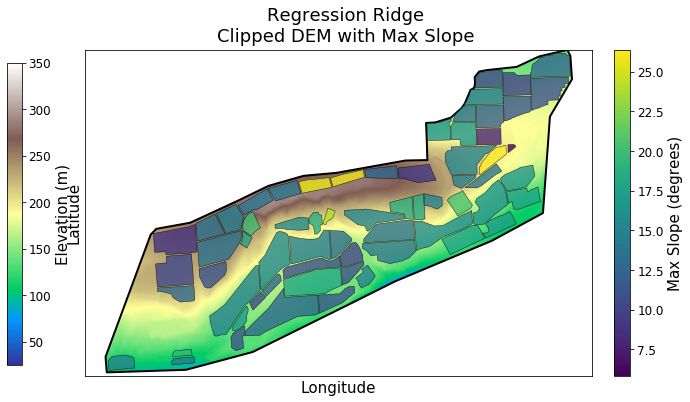

In [10]:
with rasterio.open(dem_file) as src:
    dem = src.read(1, masked=True)
    raster_crs = src.crs
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

fig, ax = plt.subplots(figsize=(10, 6))

# DEM
im = ax.imshow(
    dem,
    extent=extent,
    origin='upper',
    cmap='terrain',
    vmin=25,
    vmax=350
)

# create a new axes for the left colorbar [left, bottom, width, height]
cbar_ax_left = fig.add_axes([0.03, 0.15, 0.02, 0.7])  # tweak numbers as needed
cbar_dem = fig.colorbar(im, cax=cbar_ax_left)
cbar_dem.set_label('Elevation (m)', fontsize=15)
cbar_dem.ax.tick_params(labelsize=12)

# vineyard
vineyard.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=2)

# plot features without legend
plot_gdf = plot_features.copy()
plot_gdf.plot(
    ax=ax,
    column='slope_max',
    cmap='viridis',
    legend=False,
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

# slope colorbar on the right (default)
sm = plt.cm.ScalarMappable(
    cmap='viridis',
    norm=plt.Normalize(vmin=plot_features['slope_max'].min(),
                       vmax=plot_features['slope_max'].max())
)
sm._A = []
cbar_aspect = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.04)
cbar_aspect.set_label('Max Slope (degrees)', fontsize=15)
cbar_aspect.ax.tick_params(labelsize=12)

fig.suptitle('Regression Ridge\nClipped DEM with Max Slope', fontsize = 18)
ax.set_xlabel('Longitude', fontsize = 15)
ax.set_ylabel('Latitude', fontsize = 15)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('img/dem_w_slope.png')
plt.show()


Save our plot topography features to a pickle for later use.

In [11]:
gdf_features.to_pickle('data/plot_elev_features.pkl')